# Neuronové sítě

Na přednášce jste slyšeli úvod do další přírodou inspirované techniky - neuronových sítí. Mezi jejich nejjednodušší modely patří perceptron a vícevrstevný perceptron. Na cvičení si je tedy zkusíme sami naimplementovat.

***Důležitá poznámka:*** Níže importujeme *sklearn*. Budete-li pipem instalovat [*"sklearn"*](https://pypi.org/project/sklearn/), dost možná se vám to v nějaké formě povede nainstalovat, pravé jméno projektu / package je ale [*"scikit-learn"*](https://pypi.org/project/scikit-learn/), a tedy by měl být instalován následovně: `pip install scikit-learn`. *sklearn* je pouze jméno pro import. Je to matoucí? Jo. Ale já to nevymyslel...

In [1]:
import collections
import os

# Library tqdm is a useful tool for creating progress bars
from tqdm import trange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle

# Turns off GPU computation of Tensorflow, when that functionality is installed
# (We are using really small networks, hence the communication overhead
# is much more significant, than the computational boost we gain by utilizing
# the power of the GPU.)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

## Perceptron

Nejprve si tedy zkusíme naimplementovat jednoduchý perceptronový algoritmus učení. K tomu budeme potřebovat třídu *Perceptron*, kde si definujeme, jak jednoduchý perceptron vypadá. Při inicializaci se nastaví maximální počet iterací a learning rate, který určuje rychlost učení algoritmu, a přípraví se vektor vah a bias.

Funkce *predict* nám pro daný vstup bude predikovat jeho výstup - a to tak, že se spočítá hodnota aktivační funkce ve vstupním bodě a pokud bude větší než 0, bude aktivace 1, jinak bude aktivace 0. 

Budeme ještě potřebovat funkci *fit*, kde se budou trénovat váhy perceptronu tak, že pro daný vstup spočteme jeho predikovaný výstup a pokud je špatný, tak upravíme váhy tak, aby příště predikoval výstup správně.

In [2]:
class Perceptron:
    def __init__(self, number_of_inputs, training_iterations, learning_rate=0.1):
        self.weights = np.random.normal(size=number_of_inputs)
        self.bias = np.random.normal()
        
        self.training_iterations = training_iterations
        self.learning_rate = learning_rate
        
        
    def predict(self, inputs):
        # Compute an output of the function for the given inputs, weights and bias
        intermediate_value = np.dot(inputs, self.weights) + self.bias
        # Calculate activation
        return (np.sign(intermediate_value) + 1) / 2
    
    
    def fit(self, inputs, labels):
        for _ in range(self.training_iterations):
            for x, y in zip(inputs, labels):
                prediction = self.predict(x)               
                
                # Learning
                self.weights += self.learning_rate * (y - prediction) * x
                self.bias += self.learning_rate * (y - prediction)

Abychom náš perceptron otestovali, vygenerujeme si náhodná data pomocí knihovny *scikit-learn*, která nám umí vrátit 2 (občas i) lineárně separabilní třídy bodů.

In [3]:
inputs, labels = datasets.make_blobs(centers=2, n_samples=200)

In [4]:
perc = Perceptron(2, 100)
perc.fit(inputs, labels)

Ještě by bylo fajn umět si vizualizovat výsledky - proto si napíšeme následující funkci, která bude umět vykreslit data i oddělující nadrovinu.

In [5]:
def draw_boundary(model, inputs, labels):
    x_min = inputs[:, 0].min() - 1
    x_max = inputs[:, 0].max() + 1
    y_min = inputs[:, 1].min() - 1 
    y_max = inputs[:, 1].max() + 1

    # Create rectangular grid with the above computed dimensions
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Drawing of the decision boundary - each point gets a color accordingly
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
    predicted = predicted.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(inputs[:,0], inputs[:,1], c=labels)
    plt.contourf(xx, yy, predicted, alpha=0.4)
    plt.show()

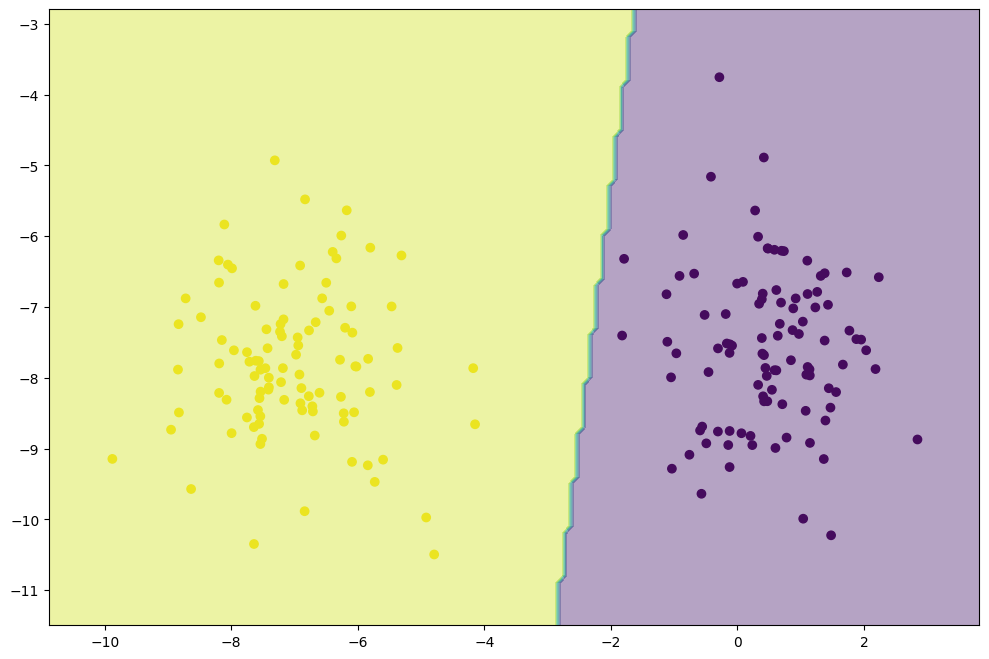

In [6]:
draw_boundary(perc, inputs, labels)

## Vícevrstvý perceptron

Jednoduchý perceptron už umíme, tak si nyní s jeho pomocí zkusíme napsat vícevrstvý perceptron, neboli celou (plně propojenou) neuronovou síť. V inicializační části nastavíme velikosti vrstev a poté matice vah mezi jednotlivými vrstvami jakožto náhodné hodnoty. Dále bude třeba umět predikovat výstupní hodnotu sítě pro daný vstup. Nakonec bude potřeba funkce trénování, která pro daný vstup spočítá výstup sítě a následně updatuje váhy pomocí backpropagace.

In [7]:
def sigmoid(x):
    # Clip the values to prevent overflows
    x = x.clip(-5e2,5e2)
    
    return 1 / (1 + np.exp(-x))


class MultiLayerPerceptron:
    def __init__(self, layer_sizes, training_iterations=1, learning_rate=0.1):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.training_iterations = training_iterations
        self.learning_rate = learning_rate
        self.last_run_activations = None
        
        for (input_layer_size, output_layer_size) in zip(self.layer_sizes, self.layer_sizes[1:]):
           self.weights.append(np.random.normal(size=(input_layer_size + 1, output_layer_size)))
           
           
    def _add_ones(self, x):
        """ Add a column of ones for bias (the first row in the weight matrix represents the biases) """
        ones = np.ones(shape=(x.shape[0], 1))
        return np.concatenate([ones, x], axis=1)
    
    
    def predict(self, inputs):
        activations = np.array(inputs)
        self.last_run_activations = [activations]
        
        try:
            for layer in self.weights:
                extended_activations = self._add_ones(activations)
                linear_combination = np.dot(extended_activations, layer)
                activations = sigmoid(linear_combination)
                self.last_run_activations.append(activations)
                
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations
    
    
    def fit(self, inputs, labels):
        progress_bar = trange(self.training_iterations)
        for i in progress_bar:
            # Compute the NN's output
            self.predict(inputs)
            
            # Perform the backpropagation
            self._perform_backpropagation(labels)
            
            # Check the performance once per hundered iterations
            if i % 100 == 0:
                predictions = self.predict(inputs)
                predicted_classes = np.argmax(predictions, axis=-1)
                model_accuracy = accuracy_score(predicted_classes, labels)
                progress_bar.set_description(f"Accuracy after iteration {i}: {model_accuracy}")
        
        
    def _perform_backpropagation(self, labels):
        # We assume a square error loss function, so L = 1/2 * sum((predictions - one_hot_targets)^2)
        one_hot_labels = np.zeros_like(self.last_run_activations[-1])
        one_hot_labels[np.arange(len(one_hot_labels)), labels] = 1
        
        # Try to implement the backpropagation yourself. - It's not easy. To be honest, it could be rather hard and maybe tricky. It is not necessary to do this,
        # so feel free to skip this one, but you can take it as a challange and check your understanding of the backpropagation
        # algorithm and of the mathematical analysis.
        # If you are willing to try, you can do so by following the ensuing steps, or do it in any other way you like.
    
        # Compute the gradients of the loss with respect to inputs of all the layers (except the first one)
        pass
    
        # Compute the gradients of the loss with respect to the model's parameters for all the layers and update the parameters
        pass

In [8]:
mlp = MultiLayerPerceptron([3,5,2])
# Predicting in batch
mlp.predict(np.array([[1,2,3], [1,2,7]]))

array([[0.01699691, 0.79837746],
       [0.01822596, 0.80348027]])

## Úkol na cvičení

Zkuste si dopsat funkci `fit`, resp. `_perform_backpropagation` u vícevrstevného perceptronu a natrénovat ho na datasetu *winequality-white.csv* z UCI machine learning repository. Cílem u tohoto datasetu je predikovat kvalitu vína na základě 11 změřených fyzikálních a chemických vlastností. Kvalita se hodnotí na stupnici 0-10. 

In [9]:
data = pd.read_csv("winequality-white.csv", delimiter=';')
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [10]:
counter=collections.Counter(data["quality"])
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})


Když se ale reálně podíváme na rozložení výsledných hodnot kvality vín v datasetu, tak vidíme, že většina výstupů je mezi 5 a 7. Proto si zjednoduššíme práci a dataset si upravíme tak, aby predikoval jen 3 výstupní kategorie s hodnotami 5 až 7 tak, že 3 a 4 sloučíme s 5 a zároveň 9 a 8 sloučíme se 7.

In [11]:
data["quality"].replace({3: 5, 4: 5, 8: 7, 9: 7}, inplace=True)
counter=collections.Counter(data["quality"])
print(counter)

Counter({6: 2198, 5: 1640, 7: 1060})


D:\Temp\ipykernel_15772\3835651965.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["quality"].replace({3: 5, 4: 5, 8: 7, 9: 7}, inplace=True)


Nakonec, protože klasifikace se většinou provádí do tříd *0* až *K-1*, a většina algoritmů strojového učení (včetně našich sítí) je na toto uzpůsobena, posuneme i naše labely z množiny *{5, 6, 7}* do množiny *{0, 1, 2}*.

In [12]:
data["quality"].replace({5: 0, 6: 1, 7: 2}, inplace=True)

D:\Temp\ipykernel_15772\679564709.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["quality"].replace({5: 0, 6: 1, 7: 2}, inplace=True)


Na tomto upraveném datasetu si nyní zkusíme pustit vícevrstevný perceptron. Vidíme, že výsledky jsou nám k ničemu, protože nemáme naprogramovanou funkci `fit`. Zkuste si ji doprogramovat.

(Použijte MSE jako loss funkci, resp. její variantu bez průměrování, jen s dělením součtu čtverců dvěma, tedy *1/2 \* $\Sigma$(predictions - one_hot_targets)^2*. Jednoduše se derivuje a pro naše účely dostatečně dobře funguje. Dále derivace sigmoid funkce je následovná: *($\sigma$(x))' = $\sigma$(x) \* (1 - $\sigma$(x))* A nakonec, neděste se výsledků. Pokud jim nevěříte, zkuste svou síť na blob datasetu, na kterém dále testujeme náš tensorflow keras model, na něm by to mělo jít jedna báseň. Dataset *winequality-white.csv* je dobrou ukázkou, že ne všechna data jsou "naučitelná" nějakou takto jednoduchou sítí.  Může v nich být šum, features jednotlivých dat nemusí být pro klasifikaci dostatečné, tedy potřebovali bychom v datasetu další informace, a podobně. Vidíme to koneckonců, i když použijeme na konci tohoto notebooku tf keras síť, i ona dosáhne ve výsledku jen lehce nadpoloviční přesnosti - a to má na rozdíl od nás alespoň nějaké techniky, kterými se brání tomu skončit v lokálním optimu.)

In [13]:
labels = data["quality"].values
inputs = data.drop(columns="quality").values

inputs.shape

(4898, 11)

In [14]:
mlp = MultiLayerPerceptron([inputs.shape[1], 5, len(np.unique(labels))])
mlp.fit(inputs, labels)
mlp.predict(inputs)

Accuracy after iteration 0: 0.3156390363413638: 100%|██████████| 1/1 [00:00<00:00, 83.50it/s]


array([[0.40777822, 0.26971605, 0.23760719],
       [0.42379752, 0.47169863, 0.08850389],
       [0.40777819, 0.26971618, 0.23760754],
       ...,
       [0.40777822, 0.26971605, 0.23760719],
       [0.40777828, 0.26971664, 0.23760647],
       [0.40777822, 0.26971605, 0.23760719]])

## Knihovny tensorflow, keras, scikit-learn

Nejprve se seznámíme s pár základními knihovnami, které budeme používat pro snažší vytváření neuronových sítí a práci s nimi. Knihovna tensorflow je symbolická matematická knihovna, která slouží pro dataflow, tedy obsahuje grafové moduly a operace, nad kterými se následně dají implementovat různé algoritmy strojového učení. Nad ní běží knihovna keras, která je navržena pro snadné experimentování s hlubokými neuronovými sítěmi. Knihovna scikit-learn zase obsahuje všechny možné běžné algoritmy strojového učení.

Všechny tyto knihovny byly navrženy, aby uživateli zjednodušily práci se zpracováním dat a následné vytváření predikčních a jiných modelů, ať už pomocí neurovnových sítí nebo jiných algoritmů strojového učení.

Zkusíme si tedy s pomocí těchto knihoven naimplementovat tu samou jednoduchou neuronovou sít, jakou jsme si ručně napsali výše. Budeme si potřebovat vyrobit data, potom definovat síť a nakonec ji natrénovat na trénovacích datech a nechat ji predikovat a změřit svou chybu na testovacích datech.

Nejprve si vytvoříme náhodná dvojrozměrná data klasifikovatelná do n tříd, abychom si je mohli i hezky vizualizovat v grafu. K tomu bude potřeba si upravit funkci pro vizualizaci, protože vícetřídová klasifikace nám vrací výstup jakožto pole, kde pro danou jednu vybranou třídu (ideálně) bude na jejím indexu 1 a všude jinde budou 0. Tomuto výstupu se tak říká one-hot-encoding.

In [15]:
def draw_boundary_multiclass(model, inputs, labels):
    x_min = inputs[:, 0].min() - 1
    x_max = inputs[:, 0].max() + 1
    y_min = inputs[:, 1].min() - 1 
    y_max = inputs[:, 1].max() + 1

    # Create rectangular grid with the above computed dimensions
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Drawing of the decision boundary - each point gets a color accordingly
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Extracting the predicted class number from the one-hot-encoding
    predicted = np.argmax(predicted, axis=1)
    
    predicted = predicted.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(inputs[:,0], inputs[:,1], c=labels)
    plt.contourf(xx, yy, predicted, alpha=0.4)
    plt.show()
    

Když máme upravenou funkci pro vizualizaci, vygenerujeme si náhodná data, vytvoříme model a podíváme se, jak byl model úspěšný, tedy jak dobře se natrénoval na trénovacích datech a jak umí predikovat data testovací.

In [16]:
# First let us prepare the data and split them to train and test sets
num_of_classes = 3
x, y = datasets.make_blobs(n_samples=300, centers=num_of_classes)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]


In [17]:
# Define the network architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(5, activation=tf.nn.sigmoid)) # Inner layer with 5 neurons
model.add(tf.keras.layers.Dense(num_of_classes, activation=tf.nn.softmax)) # Output layer

# Set the optimization process hyperparameters
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model on the training data
model.fit(x_train, y_train, epochs=200, verbose=1)
pass

Epoch 1/200
8/8 [==============================] - 1s 3ms/step - loss: 1.2755 - accuracy: 0.3280
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 1.2107 - accuracy: 0.3280
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 1.1540 - accuracy: 0.3280
Epoch 4/200
8/8 [==============================] - 0s 2ms/step - loss: 1.1039 - accuracy: 0.3280
Epoch 5/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0601 - accuracy: 0.3280
Epoch 6/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0225 - accuracy: 0.3280
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.3280
Epoch 8/200
8/8 [==============================] - 0s 2ms/step - loss: 0.9641 - accuracy: 0.3280
Epoch 9/200
8/8 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.3280
Epoch 10/200
8/8 [==============================] - 0s 3ms/step - loss: 0.9220 - accuracy: 0.3280
Epoch 11/200
8/8 [===========

553/553 [==============================] - 1s 1ms/step


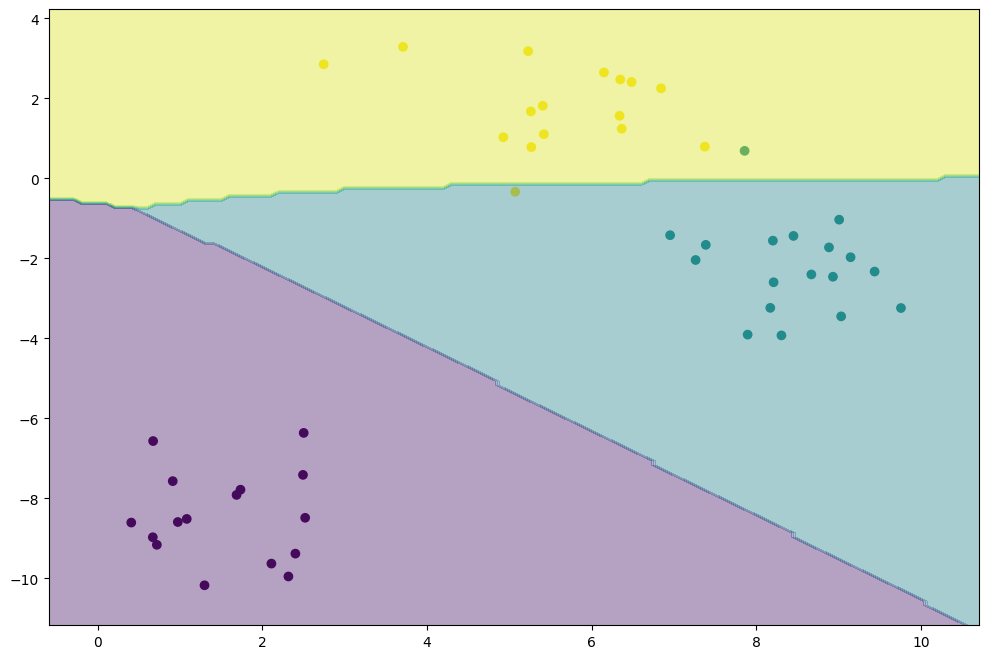

In [18]:
# We make and plot predictions on the test data
draw_boundary_multiclass(model, x_test, y_test)

Ještě si zkusíme pustit neuronovou síť z tensorflow na nějakém reálném datasetu. Nejjednodušší volbou je dataset o víně, který jsme si už popsali výše. Nejdříve ale ještě provedeme normalizaci hodnot v datasetu tak, že všechny sloupečky budou mít hodnoty v intervalu \[0, 1\]. Normalizace se dělá proto, aby se nestalo, že některý sloupeček s hodně vysokými hodnotami bude mít příliš velký vliv na výsledný predikovaný label. 

In [19]:
# Randomly shuffle the data
data = shuffle(data)

# Get the labels
labels = data["quality"].values

# Data normalization
values = data.drop(columns="quality").values
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(values)

# Split the data to train and test sets
x, y = data_scaled, labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [20]:
# Define the network architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(5, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

# Set the optimization process hyperparameters
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model on the training data
model.fit(x_train, y_train, epochs=200, verbose=1)
pass

Epoch 1/200
115/115 [==============================] - 1s 2ms/step - loss: 1.1578 - accuracy: 0.3362
Epoch 2/200
115/115 [==============================] - 0s 4ms/step - loss: 1.0766 - accuracy: 0.3654
Epoch 3/200
115/115 [==============================] - 0s 2ms/step - loss: 1.0630 - accuracy: 0.4457
Epoch 4/200
115/115 [==============================] - 0s 2ms/step - loss: 1.0610 - accuracy: 0.4454
Epoch 5/200
115/115 [==============================] - 0s 3ms/step - loss: 1.0605 - accuracy: 0.4454
Epoch 6/200
115/115 [==============================] - 0s 3ms/step - loss: 1.0603 - accuracy: 0.4454
Epoch 7/200
115/115 [==============================] - 1s 5ms/step - loss: 1.0602 - accuracy: 0.4454
Epoch 8/200
115/115 [==============================] - 0s 3ms/step - loss: 1.0601 - accuracy: 0.4454
Epoch 9/200
115/115 [==============================] - 0s 2ms/step - loss: 1.0599 - accuracy: 0.4454
Epoch 10/200
115/115 [==============================] - 0s 2ms/step - loss: 1.0597 - accura

Zkusíme si predikovat výstup na testovacích datech a spočítat přesnost. 

In [21]:
# Prediction on the test data
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=-1)
model_accuracy = accuracy_score(predicted_classes, y_test)
print(model_accuracy)

39/39 [==============================] - 0s 2ms/step
0.5338775510204081


Na závěr se podíváme na matici konfuze, která nám říká, která třída byla kolikrát dobře nebo zle predikovaná.

Confusion matrix of our MLP:
[[207 198   0]
 [115 447   0]
 [ 19 239   0]]


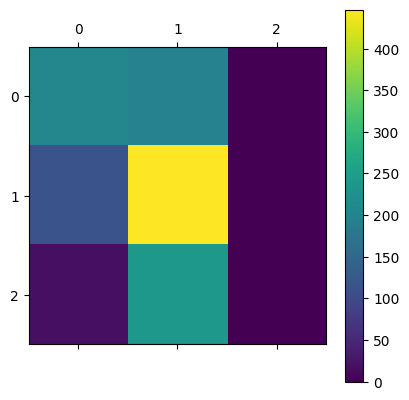

How the confusion matrix looks like for the perfect classifier:
[[405   0   0]
 [  0 562   0]
 [  0   0 258]]


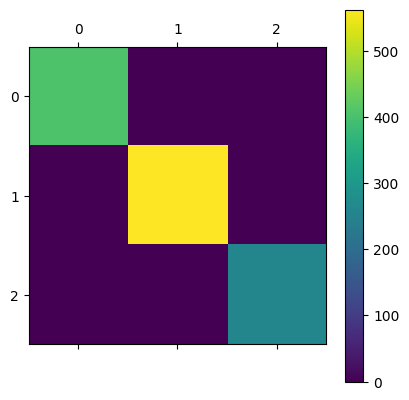

In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_classes)
print("Confusion matrix of our MLP:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()

confusion_matrix = metrics.confusion_matrix(y_test, y_test)
print("How the confusion matrix looks like for the perfect classifier:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()